In [1]:
import numpy as np

from sklearn.cross_decomposition import CCA
import hickle as hkl

from PIL import Image
from IPython.display import display
from skimage.transform import resize
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def arr_to_rgb(arr):
    l = np.copy(arr)
    l_red = np.copy(l[..., 2])
    l_blue = np.copy(l[..., 0])
    l[..., 0] = l_red
    l[..., 2] = l_blue
    l = np.clip(l, 0, np.percentile(l, 95, axis = (0, 1)))
    maxes = np.array(np.max(l, axis = (0, 1)))
    l = l / maxes
    l = Image.fromarray((l * 255).astype(np.uint8), 'RGB')
    return l, maxes

In [83]:
def identify_pifs(src, ref):
    # Canonical correlation analysis is used to identify psuedo-invariant features
    # We assume that phenological or atmospheric differences are linear
    # While land-use change or cloud cover is non-linear
    # We select the points between src and ref that are the most correlated
    # By doing CCA and selecting the pixels where the components are the closest
    cca = CCA(n_components=2, tol=1e-5, max_iter=1000)
    xs, ys = cca.fit_transform(src, ref)
    diffs = xs - ys
    # Mean squared error
    diffs = np.sum((diffs / np.std(diffs, axis=0))**2, axis=1)
    diffs = np.argwhere(diffs < np.percentile(diffs, 5))
    return src[diffs].squeeze(), ref[diffs].squeeze()

pifs_src, pifs_ref = identify_pifs(x2017.reshape((x2017.shape[0]*x2017.shape[1], x2017.shape[-1])),
                     x2020.reshape((x2020.shape[0]*x2020.shape[1], x2020.shape[-1])))

In [85]:
from sklearn.linear_model import LinearRegression
std_mult = np.ones((16))
addition = np.zeros((16))
for i in range(16):
    model = LinearRegression().fit(
        pifs_src[..., i][..., np.newaxis],
        pifs_ref[..., i][..., np.newaxis])
    std_mult[..., i] = model.coef_
    addition[
        ...,
        i] = model.intercept_  #(model.intercept_, model.coef_)

In [47]:
x2017 = x2017 * std_mult + addition

In [86]:
def reshape_fit_cca(x, y):
    shapes = x.shape
    #x = np.float32(x) / 65535
    #y = np.float32(y) / 65535
    x = x.reshape(x.shape[0]*x.shape[1], x.shape[-1])
    y = y.reshape(y.shape[0]*y.shape[1], y.shape[-1])
    cca = CCA(n_components=3)
    cca.fit(x, y)
    xs = cca.transform(x)
    ys = cca.transform(y)
    diffs = abs(xs - ys)
    diffs = np.sum(diffs, axis = 1)
    diffs = diffs.reshape(shapes[0], shapes[1])
    cutoff = np.percentile(diffs.flatten(), 1)

    new = np.ones_like(diffs)
    new[np.where(diffs < cutoff)] = 0.
    return new, diffs

def cva(X, Y):
    #X = np.float32(X) / 65535#65535
    #Y = np.float32(Y) / 65535#65535
    #X = np.float32(X[..., :10]) #/ 1000
    #Y = np.float32(Y[..., :10]) / 1000
    diff = np.abs(X - Y)
    diff_s = (diff**2).sum(axis=-1)

    return np.sqrt(diff_s)

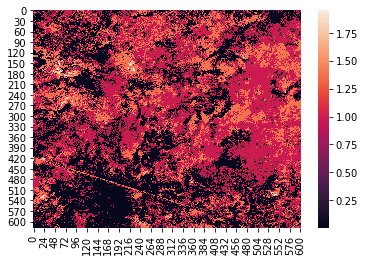

In [88]:
diff = cva(x2017, x2020)
sns.heatmap(diff)

In [80]:
bbx = [-88.88887777777776, 14.111122222222221, -88.83332222222222, 14.166677777777778]
import rasterio
def write_tif(arr: np.ndarray,
              point: list,
              x: int,
              y: int,
              out_folder: str,
              suffix="_DSFA") -> str:
    #! TODO: Documentation

    file = out_folder + f"{str(x)}X{str(y)}Y{suffix}.tif"

    west, east = point[0], point[2]
    north, south = point[3], point[1]
    #arr = arr.T.astype(np.uint8)

    transform = rasterio.transform.from_bounds(west=west,
                                               south=south,
                                               east=east,
                                               north=north,
                                               width=arr.shape[1],
                                               height=arr.shape[0])

    print("Writing", file)
    new_dataset = rasterio.open(file,
                                'w',
                                driver='GTiff',
                                height=arr.shape[0],
                                width=arr.shape[1],
                                count=1,
                                dtype="float32",
                                compress='lzw',
                                crs='+proj=longlat +datum=WGS84 +no_defs',
                                transform=transform)
    new_dataset.write(arr, 1)
    new_dataset.close()
    return file

write_tif(d, bbx, '381', 1218, "")

Writing 381X1218Y_DSFA.tif


'381X1218Y_DSFA.tif'

In [63]:
import tensorflow as tf

#from tensorflow.python.ops.gen_array_ops import transpose
#from tensorflow.python.platform.tf_logging import log


class DSFANet(object):
    def __init__(self, num=None):
        self.num = num
        self.output_num = 6
        self.hidden_num = 64
        self.layers = 2
        self.reg = 1e-4
        self.activation = tf.nn.softsign
        self.init = tf.initializers.he_normal()

    def DSFA(self, X, Y):

        #m, n = tf.shape(X)
        X_hat = X - tf.reduce_mean(X, axis=0)
        Y_hat = Y - tf.reduce_mean(Y, axis=0)

        differ = X_hat - Y_hat

        A = tf.matmul(differ, differ, transpose_a=True)
        A = A/self.num

        Sigma_XX = tf.matmul(X_hat, X_hat, transpose_a=True)
        Sigma_XX = Sigma_XX / self.num + self.reg * tf.eye(self.output_num)
        Sigma_YY = tf.matmul(Y_hat, Y_hat, transpose_a=True)
        Sigma_YY = Sigma_YY / self.num + self.reg * tf.eye(self.output_num)

        B = (Sigma_XX+Sigma_YY)/2

        # For numerical stability.
        D_B, V_B = tf.self_adjoint_eig(B)
        idx = tf.where(D_B > 1e-12)[:, 0]
        D_B = tf.gather(D_B, idx)
        V_B = tf.gather(V_B, idx, axis=1)
        B_inv = tf.matmul(tf.matmul(V_B, tf.diag(tf.reciprocal(D_B))), tf.transpose(V_B))
        ##

        Sigma = tf.matmul(B_inv, A)
        loss = tf.trace(tf.matmul(Sigma, Sigma))

        return loss

    def forward(self, X, Y):

        for k in range(self.layers):
            X = tf.layers.dense(inputs=X, units=self.hidden_num, activation=self.activation, use_bias=True,)
            Y = tf.layers.dense(inputs=Y, units=self.hidden_num, activation=self.activation, use_bias=True,)

        self.X_ = tf.layers.dense(inputs=X, units=self.output_num, activation=self.activation, use_bias=True,)
        self.Y_ = tf.layers.dense(inputs=Y, units=self.output_num, activation=self.activation, use_bias=True,)

        loss = self.DSFA(self.X_, self.Y_)

        return loss
    
    


In [64]:
import scipy
from sklearn.cluster import KMeans

def SFA(X, Y):
    '''
    see http://sigma.whu.edu.cn/data/res/files/SFACode.zip
    '''
    norm_flag = True
    m, n = np.shape(X)
    meanX = np.mean(X, axis=0)
    meanY = np.mean(Y, axis=0)

    stdX = np.std(X, axis=0)
    stdY = np.std(Y, axis=0)

    Xc = (X - meanX) / stdX
    Yc = (Y - meanY) / stdY

    Xc = Xc.T
    Yc = Yc.T

    A = np.matmul((Xc-Yc), (Xc-Yc).T)/m
    B = (np.matmul(Yc, Yc.T)+np.matmul(Yc, Yc.T))/2/m

    D, V = scipy.linalg.eig(A, B)  # V is column wise
    D = D.real
    #idx = D.argsort()
    #D = D[idx]

    if norm_flag is True:
        aux1 = np.matmul(np.matmul(V.T, B), V)
        aux2 = 1/np.sqrt(np.diag(aux1))
        V = V * aux2
    #V = V[:,0:3]
    X_trans = np.matmul(V.T, Xc).T
    Y_trans = np.matmul(V.T, Yc).T

    return X_trans, Y_trans


def main(X, Y, diff):
    X = np.float32(X) / 65535# / 1000
    Y = np.float32(Y) / 65535# / 1000
    shapes = diff.shape
    diff = diff.reshape(diff.shape[0]*diff.shape[1])
    
    nfeat = X.shape[-1]
    X = X[..., :nfeat].reshape(X.shape[0]*X.shape[1], nfeat)
    Y = Y[..., :nfeat].reshape(Y.shape[0]*Y.shape[1], nfeat)
    print(X.shape, Y.shape)

    train_num = 5000
    max_iters = 5000
    lr = 1e-4

    index = np.argsort(diff)
    XData = X[index[0:train_num], :]
    YData = Y[index[0:train_num], :]

    inputX = tf.placeholder(dtype=tf.float32, shape=[None, X.shape[-1]])
    inputY = tf.placeholder(dtype=tf.float32, shape=[None, Y.shape[-1]])
    model = DSFANet(num=train_num)
    loss = model.forward(X=inputX, Y=inputY)

    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    init = tf.global_variables_initializer()

    #gpu_options = tf.GPUOptions(allow_growth=True)
   # conf = tf.ConfigProto(gpu_options=gpu_options)
    sess = tf.Session()

    sess.run(init)

    train_loss = np.zeros(max_iters)

    for k in range(max_iters):

        _, train_loss[k] = sess.run([optimizer, loss], feed_dict={inputX: XData, inputY: YData})

        if k % 100 == 0:
            print('iter %4d, loss is %.4f' % (k, train_loss[k]))

    XTest, YTest = sess.run([model.X_, model.Y_], feed_dict={inputX: X, inputY: Y})

    sess.close()

    X_trans, Y_trans = SFA(XTest, YTest)

    diff = X_trans-Y_trans
    diff = diff / np.std(diff, axis=0)
    diff = (diff**2).sum(axis=1)
    #bin = KMeans(n_clusters=2).fit((diff**2).sum(axis=-1, keepdims=True)).labels_
    diff = np.reshape(diff, (shapes[0], shapes[1]))
    return diff

In [140]:
d = main(x2017, x2020, diff)

(372036, 16) (372036, 16)
iter    0, loss is 0.0351
iter  100, loss is 0.0322
iter  200, loss is 0.0298
iter  300, loss is 0.0277
iter  400, loss is 0.0260
iter  500, loss is 0.0244
iter  600, loss is 0.0230
iter  700, loss is 0.0218
iter  800, loss is 0.0207
iter  900, loss is 0.0198
iter 1000, loss is 0.0189
iter 1100, loss is 0.0181
iter 1200, loss is 0.0174
iter 1300, loss is 0.0167
iter 1400, loss is 0.0161
iter 1500, loss is 0.0155
iter 1600, loss is 0.0150
iter 1700, loss is 0.0145
iter 1800, loss is 0.0140
iter 1900, loss is 0.0136
iter 2000, loss is 0.0132
iter 2100, loss is 0.0128
iter 2200, loss is 0.0125
iter 2300, loss is 0.0122
iter 2400, loss is 0.0119
iter 2500, loss is 0.0116
iter 2600, loss is 0.0113
iter 2700, loss is 0.0110
iter 2800, loss is 0.0108
iter 2900, loss is 0.0105
iter 3000, loss is 0.0103
iter 3100, loss is 0.0101
iter 3200, loss is 0.0099
iter 3300, loss is 0.0097
iter 3400, loss is 0.0095
iter 3500, loss is 0.0093
iter 3600, loss is 0.0091
iter 3700, l

In [231]:
#d = np.clip(d, np.percentile(d, 2), 5)
d = d / np.max(d)
d = d ** 2

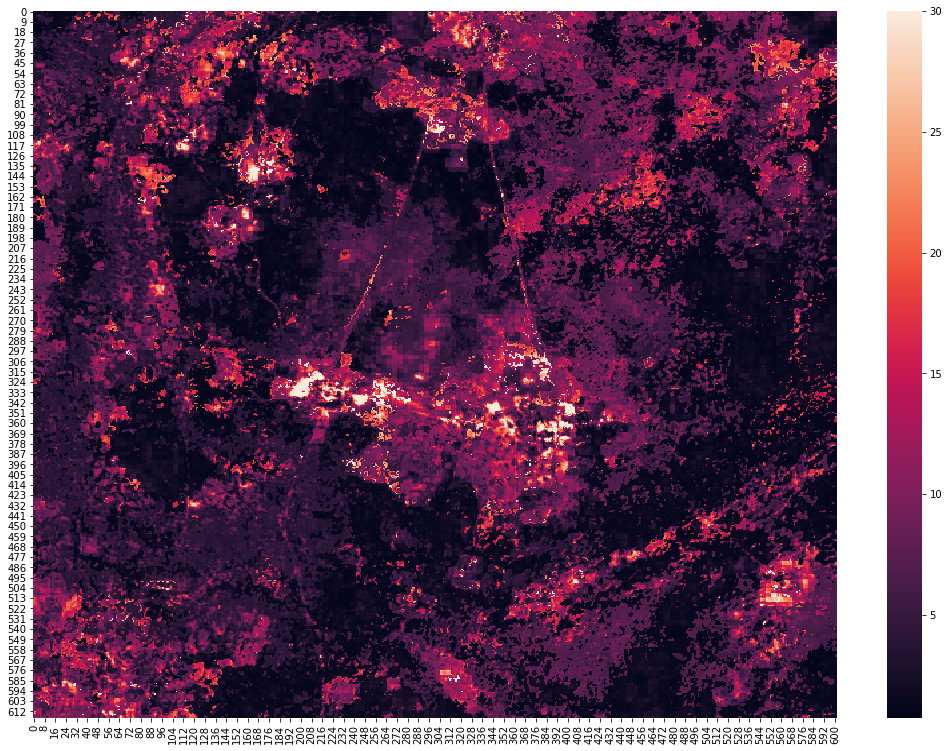

In [141]:
plt.figure(figsize=(18,13))
sns.heatmap(d, vmax = 30)

In [66]:
from scipy.cluster.vq import kmeans as km

def linear_sfa(fcx, fcy, vp, shape):
    
    delta = np.matmul(fcx, vp) - np.matmul(fcy, vp)
    differ_map = delta
    magnitude = np.sum(delta**2 / np.var(delta, axis = 0), axis=1)
    vv = magnitude / np.max(magnitude)
    im = np.reshape(kmeans(vv), shape)
    return im, magnitude, differ_map


def kmeans(data):
    shape = np.shape(data)
    ctr, _ = km(data, 2)

    for k1 in range(shape[0]):
        if abs(ctr[0] - data[k1]) >= abs(ctr[1] - data[k1]):
            data[k1] = 0
        else:
            data[k1] = 1
    return data


import tensorflow as tf
import logging

logging.basicConfig(format='%(asctime)-15s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)

def dsfa(xtrain, ytrain, xtest, ytest, net_shape=None):

    train_num = np.shape(xtrain)[0]
    bands = np.shape(xtrain)[-1]

    tf.reset_default_graph()

    activation = tf.nn.softsign

    xd = tf.placeholder(dtype=tf.float32, shape=[None, bands])
    yd = tf.placeholder(dtype=tf.float32, shape=[None, bands])

    # fc1
    fc1w1 = tf.Variable(tf.truncated_normal(shape=[bands, net_shape[0]], dtype=tf.float32, stddev=1e-1))
    fc1w2 = tf.Variable(tf.truncated_normal(shape=[bands, net_shape[0]], dtype=tf.float32, stddev=1e-1))
    fc1b1 = tf.Variable(tf.constant(1e-1, shape=[net_shape[0]], dtype=tf.float32))
    fc1b2 = tf.Variable(tf.constant(1e-1, shape=[net_shape[0]], dtype=tf.float32))

    fc1x = tf.nn.bias_add(tf.matmul(xd, fc1w1), fc1b1)
    fc1y = tf.nn.bias_add(tf.matmul(yd, fc1w2), fc1b2)

    fc11 = activation(fc1x)
    fc12 = activation(fc1y)

    # fc2
    fc2w1 = tf.Variable(tf.truncated_normal(shape=[net_shape[0], net_shape[1]], dtype=tf.float32, stddev=1e-1))
    fc2w2 = tf.Variable(tf.truncated_normal(shape=[net_shape[0], net_shape[1]], dtype=tf.float32, stddev=1e-1))
    fc2b1 = tf.Variable(tf.constant(1e-1, shape=[net_shape[1]], dtype=tf.float32))
    fc2b2 = tf.Variable(tf.constant(1e-1, shape=[net_shape[1]], dtype=tf.float32))

    fc2x = tf.nn.bias_add(tf.matmul(fc11, fc2w1), fc2b1)
    fc2y = tf.nn.bias_add(tf.matmul(fc12, fc2w2), fc2b2)

    fc21 = activation(fc2x)
    fc22 = activation(fc2y)

    # fc3
    fc3w1 = tf.Variable(tf.truncated_normal(shape=[net_shape[1], net_shape[2]], dtype=tf.float32, stddev=1e-1))
    fc3w2 = tf.Variable(tf.truncated_normal(shape=[net_shape[1], net_shape[2]], dtype=tf.float32, stddev=1e-1))
    fc3b1 = tf.Variable(tf.constant(1e-1, shape=[net_shape[2]], dtype=tf.float32))
    fc3b2 = tf.Variable(tf.constant(1e-1, shape=[net_shape[2]], dtype=tf.float32))

    fc3x = tf.nn.bias_add(tf.matmul(fc21, fc3w1), fc3b1)
    fc3y = tf.nn.bias_add(tf.matmul(fc22, fc3w2), fc3b2)

    fc3x = activation(fc3x)
    fc3y = activation(fc3y)

    #fc3x - tf.cast(tf.divide(1, bands), tf.float32) * tf.matmul(fc3x, tf.ones([bands, bands]))
    m = tf.shape(fc3x)[1]
    fc_x = fc3x - tf.cast(tf.divide(1, m), tf.float32) * tf.matmul(fc3x, tf.ones([m, m]))
    fc_y = fc3y - tf.cast(tf.divide(1, m), tf.float32) * tf.matmul(fc3y, tf.ones([m, m]))

    Differ = fc_x - fc_y

    A = tf.matmul(Differ, Differ, transpose_a=True)
    A = A / train_num

    sigmaX = tf.matmul(fc_x, fc_x, transpose_a=True)
    sigmaY = tf.matmul(fc_y, fc_y, transpose_a=True)
    sigmaX = sigmaX / train_num + 1e-4  * tf.eye(net_shape[-1])
    sigmaY = sigmaY / train_num + 1e-4  * tf.eye(net_shape[-1])

    B = (sigmaX + sigmaY) / 2# + args.reg * tf.eye(net_shape[-1])

    # B_inv, For numerical stability.
    D_B, V_B = tf.self_adjoint_eig(B)
    idx = tf.where(D_B > 1e-12)[:, 0]
    D_B = tf.gather(D_B, idx)
    V_B = tf.gather(V_B, idx, axis=1)
    B_inv = tf.matmul(tf.matmul(V_B, tf.diag(tf.reciprocal(D_B))), tf.transpose(V_B))

    sigma = tf.matmul(B_inv, A)#+ args.reg * tf.eye(net_shape[-1])

    D, V = tf.self_adjoint_eig(sigma)
    
    #loss = tf.sqrt(tf.trace(tf.matmul(sigma,sigma)))
    loss = tf.trace(tf.matmul(sigma,sigma))

    optimizer = tf.train.GradientDescentOptimizer(1e-4).minimize(loss)

    init = tf.global_variables_initializer()

    loss_log = []

    sess = tf.Session()

    sess.run(init)

    for k in range(2500):
        sess.run(optimizer, feed_dict={xd: xtrain, yd: ytrain})

        if k % 100 == 0:
            ll = sess.run(loss, feed_dict={xd: xtrain, yd: ytrain})
            ll = ll / net_shape[-1]
            logging.info('The %4d-th epochs, loss is %4.4f ' % (k, ll))
            loss_log.append(ll)

    matV = sess.run(V, feed_dict={xd: xtest, yd: ytest})
    bVal = sess.run(B, feed_dict={xd: xtest, yd: ytest})

    fcx = sess.run(fc_x, feed_dict={xd: xtest, yd: ytest})
    fcy = sess.run(fc_y, feed_dict={xd: xtest, yd: ytest})

    sess.close()
    print('')

    return loss_log, matV, fcx, fcy, bVal

In [90]:
X = x2017#np.float32(x2017) / 65535# / 1000
Y = x2020#np.float32(x2020) / 65535# / 1000
#diff = l
shapes = diff.shape
#diff = diff.reshape(diff.shape[0]*diff.shape[1])

nfeats = X.shape[-1]
X = X[..., :nfeats].reshape(X.shape[0]*X.shape[1], nfeats)
Y = Y[..., :nfeats].reshape(Y.shape[0]*Y.shape[1], nfeats)
print(X.shape, Y.shape)

train_num = 10000
max_iters = 2000
lr = 1e-4

index = np.argsort(diff)
XData =pifs_src# X[index[0:train_num], :] # 
YData = pifs_ref # Y[index[0:train_num], :] 

(372036, 16) (372036, 16)


In [91]:
XData.shape

(18602, 16)

In [92]:
loss_log, vpro, fcx, fcy, bval = dsfa(xtrain=XData, ytrain=YData,
                                      xtest=x2017[..., :32].reshape(x2017.shape[0]*x2017.shape[1], nfeats), 
                                      ytest=x2020[..., :32].reshape(x2017.shape[0]*x2017.shape[1], nfeats),
                                      net_shape=[128, 128, 16])



12/02/2022 08:37:50 INFO: The    0-th epochs, loss is 1.8501 
12/02/2022 08:37:55 INFO: The  100-th epochs, loss is 1.3343 
12/02/2022 08:37:59 INFO: The  200-th epochs, loss is 1.0785 
12/02/2022 08:38:04 INFO: The  300-th epochs, loss is 0.8434 
12/02/2022 08:38:09 INFO: The  400-th epochs, loss is 1.1112 
12/02/2022 08:38:14 INFO: The  500-th epochs, loss is 0.7098 
12/02/2022 08:38:20 INFO: The  600-th epochs, loss is 0.4477 
12/02/2022 08:38:25 INFO: The  700-th epochs, loss is 0.9688 
12/02/2022 08:38:30 INFO: The  800-th epochs, loss is 0.9766 
12/02/2022 08:38:35 INFO: The  900-th epochs, loss is 1.0312 
12/02/2022 08:38:41 INFO: The 1000-th epochs, loss is 0.9978 
12/02/2022 08:38:46 INFO: The 1100-th epochs, loss is 1.0262 
12/02/2022 08:38:51 INFO: The 1200-th epochs, loss is 0.9988 
12/02/2022 08:38:57 INFO: The 1300-th epochs, loss is 0.9687 
12/02/2022 08:39:02 INFO: The 1400-th epochs, loss is 0.8946 
12/02/2022 08:39:07 INFO: The 1500-th epochs, loss is 0.6101 
12/02/20

In [93]:
imm, magnitude, differ_map = linear_sfa(fcx, fcy, vpro, shape=x2017.shape[:2])

magnitude = np.reshape(magnitude, x2017.shape[:2])
#magnitude = np.clip(magnitude,0, 1000)
magnitude_float = np.copy(magnitude)
differ = differ_map
#differ_map = np.reshape(differ_map, x2017.shape[:3])
change_map = np.reshape(kmeans(np.reshape(magnitude, [-1])), x2017.shape[:2])

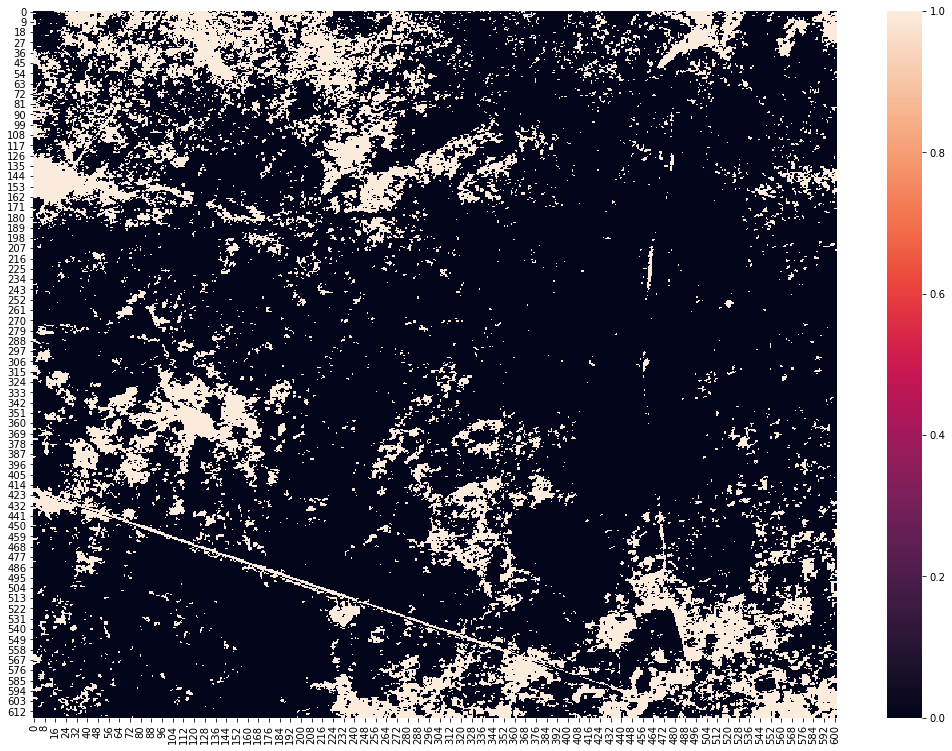

In [96]:
plt.figure(figsize=(18,13))
sns.heatmap(change_map)

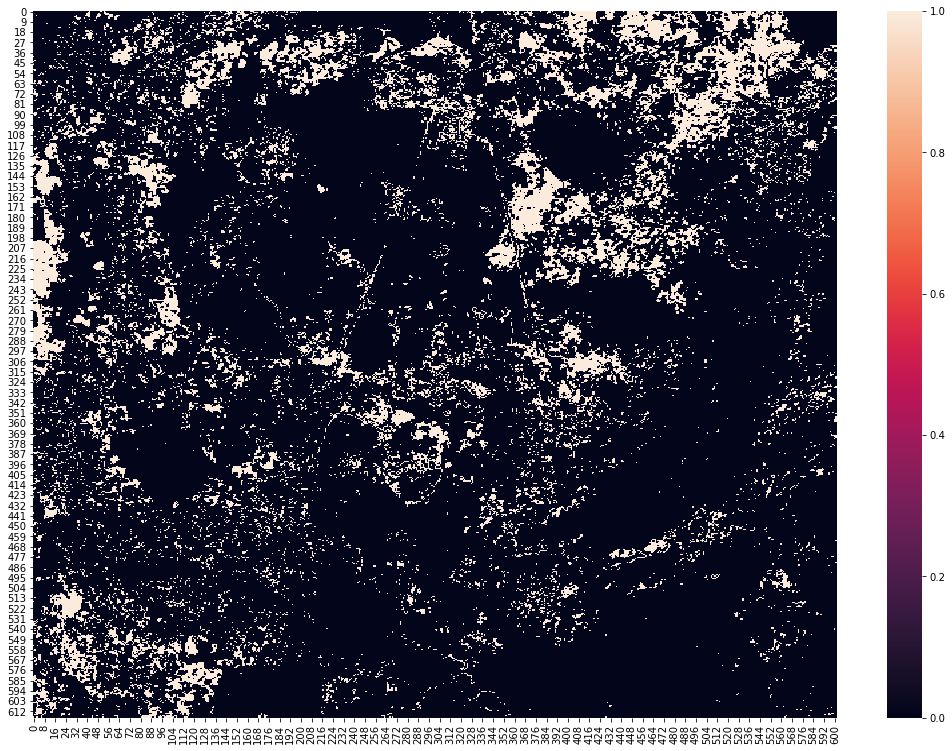

In [83]:
plt.figure(figsize=(18,13))
sns.heatmap(change_map)

In [47]:
differ.shape

(372036, 16)